In [21]:
from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit
from qiskit.circuit.library import UnitaryGate, QFT, PhaseEstimation
from qiskit_aer import Aer
from qiskit.visualization import plot_histogram
from math import log2, floor, ceil, gcd
import numpy as np
from fractions import Fraction

In [22]:
def Ua(a: int, N: int) -> UnitaryGate:
    qubit_count = len(bin(N)) - 2
    dimension = 2**qubit_count

    matrix = np.zeros([dimension, dimension], dtype=int)

    for input_state in range(N):
        output_state = (a * input_state) % N
        matrix[output_state][input_state] = 1
    
    for state in range(N, dimension):
        matrix[state][state] = 1

    return UnitaryGate(matrix, label=f"Ua({a}, {N})")

In [23]:
def find_factors(a: int, N: int, measured_phase: int, n_count: int):
    phase = measured_phase / (2**n_count)
    frac = Fraction(phase).limit_denominator(N)
    r = frac.denominator

    if r % 2 == 0:
        y = pow(a, r//2, N)
        factor1 = gcd(y-1, N)
        factor2 = gcd(y+1, N)
        
        if factor1 > 1 and factor2 > 1:
            return factor1, factor2
    
    return None


In [24]:
def shor(a: int, N: int):
    n_count = len(bin(N)[2:])
    n_phase = len(bin(N)[2:])
    
    phase_register = QuantumRegister(n_count, name='phase')
    mod_register = QuantumRegister(n_phase, name='mod')
    classical_register = ClassicalRegister(n_count, name='measured')
    
    qc = QuantumCircuit(phase_register, mod_register, classical_register)
    
    # Initialize mod register to |1>
    qc.x(mod_register[0])
    
    # Create superposition in phase register
    for i in range(n_count):
        qc.h(phase_register[i])
    
    qc.barrier()
    
    # Controlled modular multiplication
    controlled_ua = Ua(a, N).control(1)
    
    # More efficient controlled operations
    for i in range(n_count):
        controlled_ua_power = controlled_ua.power(2**i)
        qc.append(controlled_ua_power, [phase_register[i], *mod_register])
    
    qc.barrier()
    
    # Inverse QFT
    qc.append(QFT(n_count, inverse=True), phase_register)
    
    qc.measure(phase_register, classical_register)
    
    return qc

In [25]:
def algorithm(N: int, attempts: int = 100):
    if N % 2 == 0:
        return 2, N//2
    
    for attempt in range(attempts):
        a = np.random.randint(2, N)
        
        # Lucky we found factor
        if gcd(a, N) != 1:
            print(f"> Lucky we found factor where a = {a}")
            return gcd(a, N), N//gcd(a, N)
        
        print(f"Attempt {attempt + 1}, a = {a}")
        
        qc = shor(a, N)
        display(qc.draw("mpl", style="bw", fold=-1))
        simulator = Aer.get_backend('qasm_simulator')
        result = simulator.run(qc.decompose().decompose(), shots=1024).result()
        counts = result.get_counts()

        for measured_phase in counts:
            measured_decimal = int(measured_phase, 2)
            factors = find_factors(a, N, measured_decimal, len(measured_phase))
            if factors:
                return factors
    
    return None

Factoring N = 21
Attempt 1, a = 13


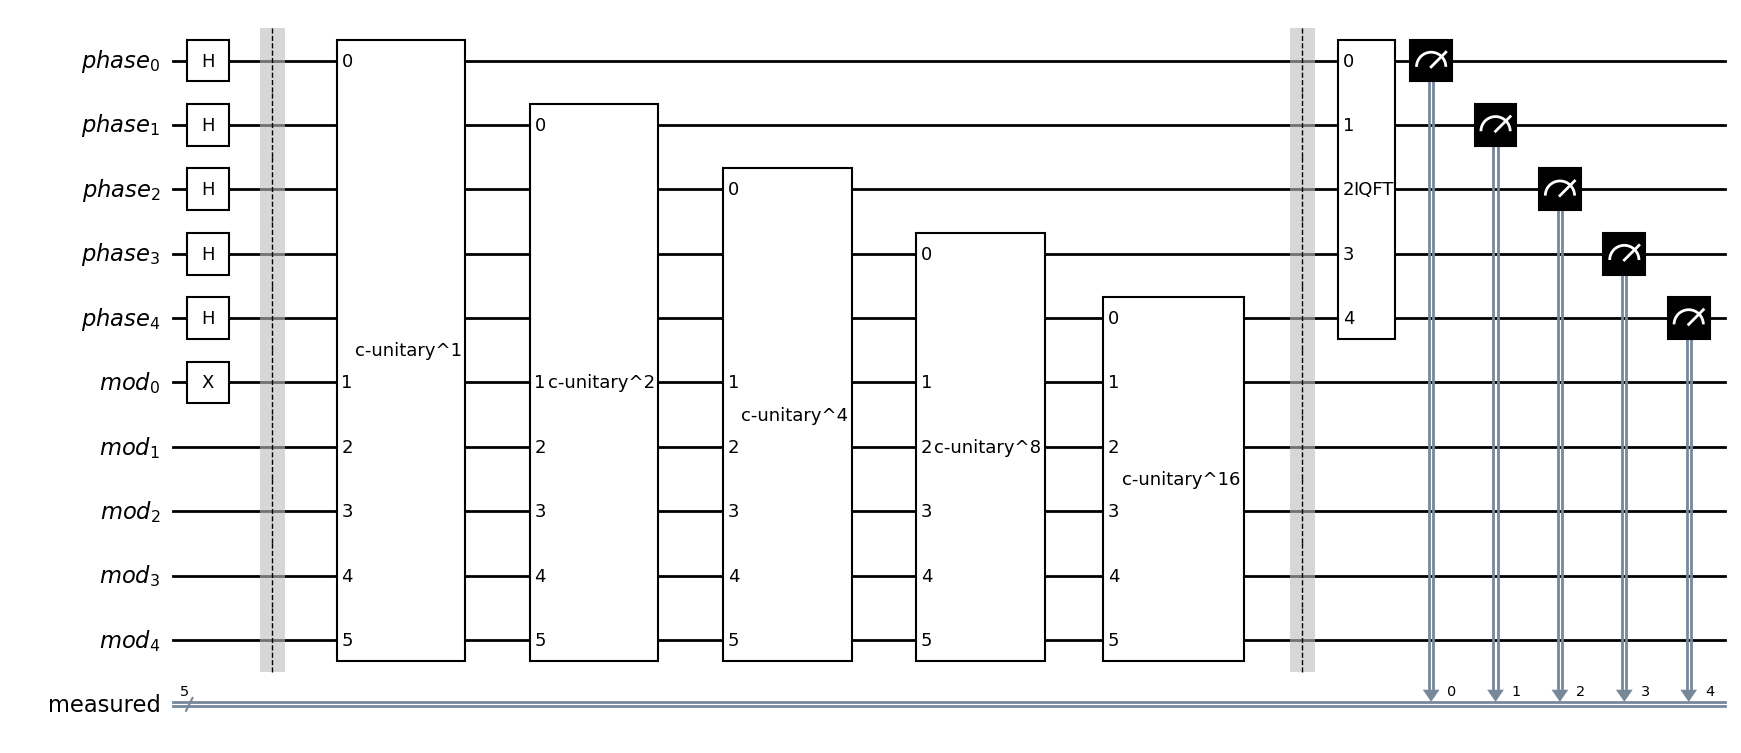


Found factors: 21 = 3 × 7


In [26]:
N = 21
print(f"Factoring N = {N}")
factors = algorithm(N)

if factors:
    p, q = factors
    print(f"\nFound factors: {N} = {p} × {q}")
else:
    print("\nFailed to find factors")